<a href="https://colab.research.google.com/github/Jmmostafa/VaRBacktestingEngine/blob/main/02_VaR_Model_Implementations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation

In [83]:
# Quickly download the data
symbols = ['^GSPC', 'GC=F', '^TNX','EURUSD=X']
names = ['EURUSD', 'GOLD', 'GSPC', '10Y']

def calc_returns(symbols, names):
  import yfinance as yf
  import pandas as pd
  import numpy as np

  df = yf.download(symbols, start = '2020-01-01', auto_adjust= True)['Close'].dropna()
  df.columns = names
  df['10Y'] = df['10Y']/100
  df_returns = np.log(df/df.shift(1)).dropna()
  return df_returns

df_returns = calc_returns(symbols, names)
df_returns.head()

[*********************100%***********************]  4 of 4 completed


,EURUSD,GOLD,GSPC,10Y
Date,,,,
2020-01-03,-0.004411,0.016072,-0.007085,-0.051237
2020-01-06,-0.000849,0.010914,0.003527,0.012782
2020-01-07,0.003223,0.003569,-0.002807,0.008796
2020-01-08,-0.003870,-0.009204,0.004890,0.025400
2020-01-09,-0.003730,-0.003667,0.006633,-0.008574


# VaR Calculations

## Historical Simulated VaR

In [84]:
def historical_var_es(df_returns, confidence_level):
  import numpy as np
  import pandas as pd

  # Sort the returns in ascending order
  sorted_returns = np.sort(df_returns)

  # Calculate VaR
  var_idx = int(np.floor((1 - confidence_level) * len(sorted_returns)))
  VaR = sorted_returns[var_idx]

  # Calculate ES
  losses_beyond_var = sorted_returns[sorted_returns <= VaR]
  ES = np.mean(losses_beyond_var)

  return VaR, ES


# Calculating VaR and ES for each asset for different confidence levels
confidence_levels = np.arange(0.90, 1.00, 0.01)
results = []

for confidence in confidence_levels:
  for asset in df_returns.columns:
    var, es = historical_var_es(df_returns[asset].values, confidence_level= confidence)
    results.append({
      'Asset': asset,
      'Confidence Level': f"{confidence*100:.0f}%",
      'VaR': var,
      'ES': es
    })

df_results = pd.DataFrame(results)
# df_results.set_index(['Asset'], inplace= True)
df_results.head()

,Asset,Confidence Level,VaR,ES
0,EURUSD,90%,-0.005649,-0.008470
1,GOLD,90%,-0.011923,-0.019904
2,GSPC,90%,-0.012396,-0.023819
3,10Y,90%,-0.029296,-0.058163
4,EURUSD,91%,-0.005978,-0.008766


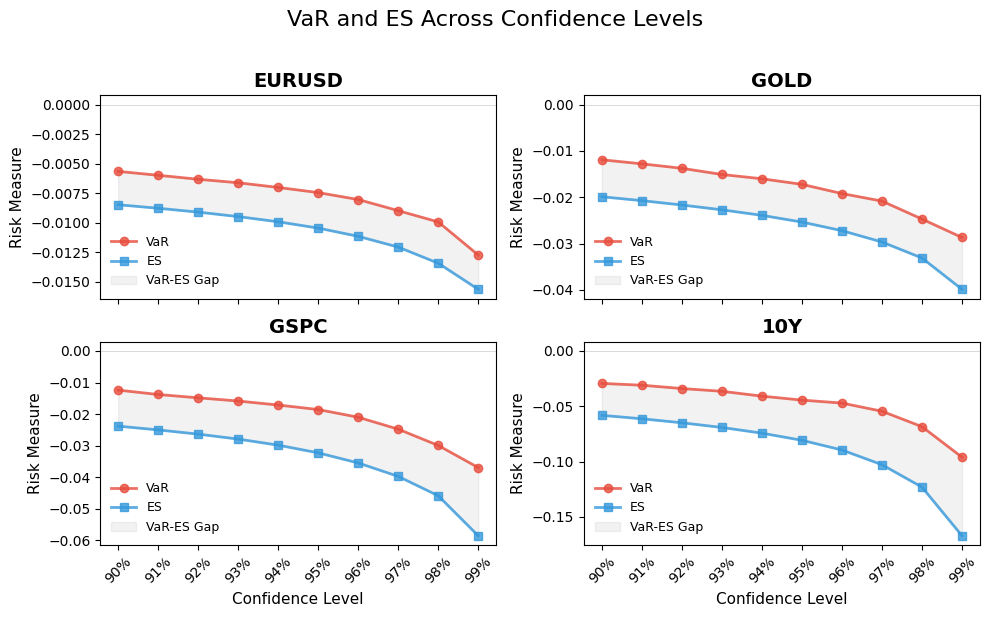

In [85]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get unique assets
assets = df_results['Asset'].unique()
n_assets = len(assets)

# If you have more than 4 assets, take only the first 4
if n_assets > 4:
    assets = assets[:4]
    n_assets = 4

# Create 2x2 subplots with shared x-axis
fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True)
axes = axes.flatten()

# Color palette for better visualization
colors = ['#E74C3C', '#3498DB']  # Red for VaR, Blue for ES

for idx, asset in enumerate(assets):
    ax = axes[idx]

    # Filter data for this asset and sort by confidence level
    asset_data = df_results[df_results['Asset'] == asset].copy()

    # Convert confidence level to numeric for proper sorting and plotting
    asset_data['Confidence_Numeric'] = asset_data['Confidence Level'].str.rstrip('%').astype(float)
    asset_data = asset_data.sort_values('Confidence_Numeric')

    # Get x-axis values
    conf_levels = asset_data['Confidence_Numeric'].values
    conf_labels = asset_data['Confidence Level'].values

    # Plot VaR and ES
    ax.plot(conf_levels, asset_data['VaR'],
            marker='o', markersize=6, label='VaR',
            linewidth=2, color=colors[0], alpha=0.8)
    ax.plot(conf_levels, asset_data['ES'],
            marker='s', markersize=6, label='ES',
            linewidth=2, color=colors[1], alpha=0.8)

    # Fill between lines (VaR-ES gap)
    ax.fill_between(conf_levels,
                    asset_data['VaR'],
                    asset_data['ES'],
                    color='gray', alpha=0.1,
                    label='VaR-ES Gap')

    # Customize each subplot
    ax.set_title(f'{asset}', fontsize=14, fontweight='bold')
    # Only set xlabel for bottom row to avoid redundancy with shared x-axis
    if idx >= n_assets - 2 or n_assets <= 2: # For 2x2 grid, idx 2 and 3 are bottom row
        ax.set_xlabel('Confidence Level', fontsize=11)
    else:
        ax.set_xlabel('') # Clear xlabel for top row
    ax.set_ylabel('Risk Measure', fontsize=11)
    ax.set_xticks(conf_levels)
    ax.set_xticklabels(conf_labels, rotation=45 if len(conf_levels) > 5 else 0, fontsize=10)

    # Add horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.2, linewidth=0.5)

    # Add grid (if desired - set to False if you prefer no grid)
    ax.grid(False)

    # Add legend to each subplot
    ax.legend(fontsize=9, loc='best', frameon = False)

# Remove empty subplots if we have less than 4 assets
for idx in range(n_assets, 4):
    axes[idx].set_visible(False)

# Add overall title
plt.suptitle('VaR and ES Across Confidence Levels', fontsize=16, y=1.02)

plt.tight_layout()
plt.show()

## Filtered Historical Simulated VaR

## Monte Carlo VaR (normal dist)

## Monte Carlo VaR (t-dist)